# Sentiment Classification in Product Reviews

## Introduction

* **Objective:**

To create an NLP model to automatically classify reviews as positive, neutral, or negative.

In [74]:
import json
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical tests
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

## 1. Extract Data

In [24]:
# reading the JSONL file
df = pd.read_json('../data/All_Beauty.jsonl', lines=True)

# Show the first few rows
df.head()

# create a copy of the original dataframe
df_original = df.copy()


In [25]:
df.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')

## 2. EDA

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  int64         
 1   title              701528 non-null  object        
 2   text               701528 non-null  object        
 3   images             701528 non-null  object        
 4   asin               701528 non-null  object        
 5   parent_asin        701528 non-null  object        
 6   user_id            701528 non-null  object        
 7   timestamp          701528 non-null  datetime64[ns]
 8   helpful_vote       701528 non-null  int64         
 9   verified_purchase  701528 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 48.8+ MB


* **📌 Data Dictionary — Amazon All_Beauty Dataset**

| **Column**          | **Type**        | **Description**                                                                      |
| ------------------- | --------------- | ------------------------------------------------------------------------------------ |
| `rating`            | int64           | Product rating given by the user, ranging from **1** (worst) to **5** (best).        |
| `title`             | object          | Title or short summary of the review.                                                |
| `text`              | object          | Full review text written by the user.                                                |
| `images`            | object          | List of image URLs uploaded by the reviewer, if available.                           |
| `asin`              | object          | Amazon Standard Identification Number — unique product ID.                           |
| `parent_asin`       | object          | Parent product ID when multiple variations exist (e.g., color, size).                |
| `user_id`           | object          | Unique identifier of the user who posted the review.                                 |
| `timestamp`         | datetime64\[ns] | Date and time when the review was posted.                                            |
| `helpful_vote`      | int64           | Number of users who marked the review as helpful.                                    |
| `verified_purchase` | bool            | Indicates whether the review comes from a verified purchase (**True** or **False**). |


In [27]:
# dataset shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset.")

There are 701528 rows and 10 columns in the dataset.


### 2.1. Missing values and Duplicated

In [28]:
# verifying missing values
df.isnull().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

There are no null values in the dataframe.

In the treatment of duplicates in product review datasets, it is important to differentiate the types of duplicity to maintain data quality. 

Firstly, there are complete duplicates, where all columns are identical; these should always be removed, as they represent redundant records that do not add any information to the model. 

Next, there are `text` duplicates, when the same review content appears multiple times, even if other information (such as user or product) is different; these cases should also be eliminated, as they can introduce bias and noise in training. 

Finally, there are duplicates by user and product, where the same user evaluated the same item more than once; in this case, it is common to keep only the most recent or the most relevant review, ensuring that each user contributes uniquely to each product. 

This approach is especially important in NLP datasets, such as product reviews, because columns with lists or objects (like images) cannot be directly compared by Pandas; therefore, we focus on relevant columns for identifying duplicates, such as text, user_id, and asin. This way, we ensure that the sentiment classification model is trained with clean, non-redundant, and representative data, improving its generalization ability.

So instead of using the original `image` column, we will create an auxiliary column to identify if the user did an upload of any image or not.


In [29]:
# creating an auxiliary column to identify if the user did an upload of any image or not
df['has_image'] = df['images'].apply(lambda x: 1 if len(x) > 0 else 0)

In [30]:
# drop the original images column
df = df.drop(columns=['images'])

In [33]:
df.duplicated().sum()


np.int64(7275)

In [34]:
# eliminating complete duplicates
df = df.drop_duplicates()

In [36]:
# verifying duplicates by 'text' column
print(f"There are {df['text'].duplicated().sum()} duplicate rows based on the 'text' column.")


There are 50624 duplicate rows based on the 'text' column.


In [37]:
# drop the duplicates by 'text' column
df = df.drop_duplicates(subset=['text'])

In [38]:
# verifying duplicates by 'user_id' and 'asin' columns
print(f"There are {df.duplicated(subset=['user_id', 'asin']).sum()} duplicate rows based on the 'user_id' and 'asin' columns.")


There are 0 duplicate rows based on the 'user_id' and 'asin' columns.


In [39]:
# Verifying the final shape of the dataset
print(f"After removing duplicates, there are {df.shape[0]} rows and {df.shape[1]} columns in the dataset.")

After removing duplicates, there are 643629 rows and 10 columns in the dataset.


In [59]:
# analysis statistics of numerical columns
df.describe()

,rating,timestamp,helpful_vote,has_image
count,643629.000000,643629,643629.000000,643629.000000
mean,3.916870,2019-04-12 16:36:31.720172032,0.977619,0.089076
min,1.000000,2000-11-01 04:24:18,0.000000,0.000000
25%,3.000000,2017-08-08 14:38:05.240000,0.000000,0.000000
50%,5.000000,2019-11-02 04:37:11.966000128,0.000000,0.000000
75%,5.000000,2021-03-08 00:52:02.455000064,1.000000,0.000000
max,5.000000,2023-09-09 00:39:36.666000,646.000000,1.000000
std,1.511491,NaN,5.669782,0.284854


### 2.2. Univariate Analysis

* **Rating Distribution**

In [40]:
# Distribution if rating
df['rating'].value_counts().sort_index()

rating
1     97535
2     41634
3     54082
4     73928
5    376450
Name: count, dtype: int64

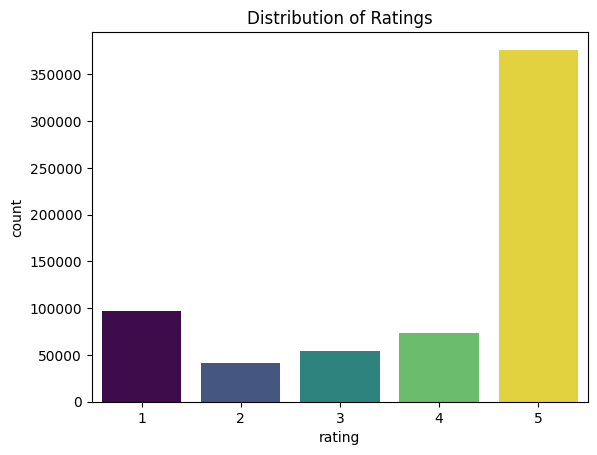

In [47]:
sns.countplot(x='rating', 
              data=df, 
              palette='viridis', 
              hue='rating')
plt.title("Distribution of Ratings")
#remove legend
plt.legend().remove()
plt.show()


We can see from the analysis above that the classes are unbalanced. We have many more evaluations with a `rating` of 5 than lower ones. We will need to use balancing techniques when we create the models.

In [48]:
# creating column 'sentiment' based on the 'rating' column
def categorize_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'
df['sentiment'] = df['rating'].apply(categorize_sentiment)
df['sentiment'].value_counts()

sentiment
positive    450378
negative    139169
neutral      54082
Name: count, dtype: int64

## 3. Bivariate Analysis

Let's do a practical analysis to understand if the auxiliary column has_image really has relevance for sentiment classification. The idea is to check if there is a statistical relationship or clear trend between having images and the sentiment of the review.

In [52]:
df.has_image.value_counts()

has_image
0    586297
1     57332
Name: count, dtype: int64

In [53]:
# checking the relationship between having images and sentiment (proportion of reviews with images by sentiment)

df.groupby('sentiment')['has_image'].value_counts(normalize=True).unstack()


has_image,0,1
sentiment,,
negative,0.920852,0.079148
neutral,0.928978,0.071022
positive,0.905688,0.094312


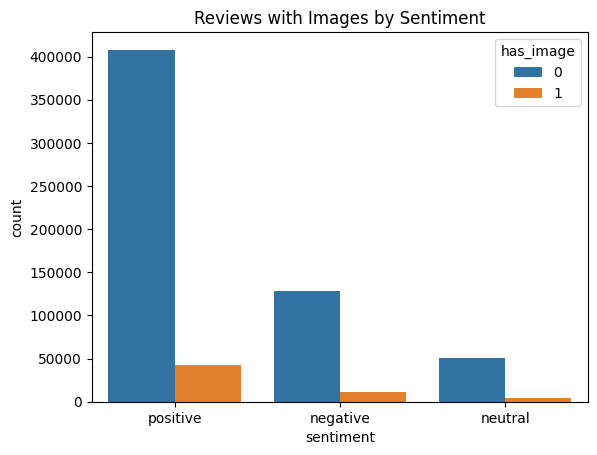

In [54]:
# visualization of the relationship between having images and sentiment
sns.countplot(x='sentiment', hue='has_image', data=df)
plt.title("Reviews with Images by Sentiment")
plt.show()


To identify whether the column is significant or not, we must perform a hypothesis test. Visually, it is not clear if there is an impact on sentiment.

* Distribution of Verified Purchases by Sentiment

In [68]:
# Converter em binário (0 = não verificado, 1 = verificado)
df['verified_purchase_flag'] = df['verified_purchase'].astype(int)
df['verified_purchase_flag'].value_counts()

verified_purchase_flag
1    579964
0     63665
Name: count, dtype: int64

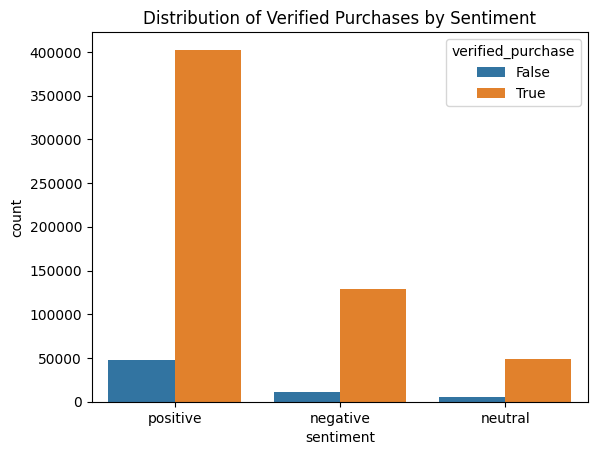

In [69]:
sns.countplot(x='sentiment', hue='verified_purchase', data=df)
plt.title("Distribution of Verified Purchases by Sentiment")
plt.show()

In [70]:
df.groupby('verified_purchase')['rating'].mean()


verified_purchase
False    4.061541
True     3.900989
Name: rating, dtype: float64

* **Average rating for unverified reviews (`False`)**: 4.06 
* **Average rating for verified reviews (`True`)**: 3.90 
--- 

**Interpretation:** 

1. **Verified reviews have, on average, a slightly lower rating**: 
    * This may indicate that users who actually purchase are slightly more critical. 

    * Unverified reviews tend to be a bit more positive, perhaps because some evaluations come from people who did not buy or who want to inflate the rating.

 2. **The difference is small (~0.16 points)**: 
 
     * It's not huge, but it can still have some value for the model. 
 
    *  The model can learn subtle patterns, especially if combined with other features (text, helpful_vote, user_avg_rating). 
 
 3. **Conclusion for the feature**: 
 
     * **It's worth keeping `verified_purchase_flag` as a binary feature** in the model. 
 

### 3.2 Hypothesis Test:

#### 3.2.1: Is there an association between reviews with images and the sentiment of the evaluation?

**Hypothesis**

- Null hypothesis (H₀): There is no significant relationship between has_image and sentiment → the presence of images does not influence sentiment.

- Alternative hypothesis (H₁): There is a significant relationship between has_image and sentiment → the presence of images influences sentiment.

**Decision criterion**

- If p-value < 0.05 → we reject H₀ → has_image is potentially relevant.

- If p-value ≥ 0.05 → we do not reject H₀ → has_image probably does not contribute.

In [57]:
contingency_table = pd.crosstab(df['sentiment'], df['has_image'])

# chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p}")

# Interpretation
if p < 0.05:
    print("\nResults: We reject the null hypothesis. There is evidence of an association between having images and the sentiment of the review.")
else:
    print("\nResults: We fail to reject the null hypothesis. There is not enough evidence of an association between having images and the sentiment of the review.")

Chi2 Statistic: 538.46
Degrees of Freedom: 2
P-value: 1.189159118371913e-117

Results: We reject the null hypothesis. There is evidence of an association between having images and the sentiment of the review.


In [58]:
import numpy as np

# 7️⃣ Cálculo de Cramér's V (força da associação)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1)))
print(f"Cramér's V: {cramers_v:.3f}")

# 8️⃣ Interpretação de Cramér's V
if cramers_v < 0.1:
    strength = "Negligible association"
elif cramers_v < 0.3:
    strength = "Weak association"
elif cramers_v < 0.5:
    strength = "Moderate association"
else:
    strength = "Strong association"

print(f"Strength of association: {strength}")

Cramér's V: 0.029
Strength of association: Negligible association


After all the teste we can conclude:

* The **p-value < 0.05** indicates that there is a statistically significant association between `has_image` and sentiment.

* However, **Cramér's V = 0.029** shows that the **strength of this association is negligible**.

* In practice, even though it is significant, the column **does not add relevant information** to the sentiment classification model.

**Conclusion:** `has_image` probably **does not need to be included** as a feature in the model.

#### 3.2.2: Is the difference in average rating between verified and non-verified reviews statistically significant?

In [ ]:
verified_ratings = df[df['verified_purchase']==True]['rating']
non_verified_ratings = df[df['verified_purchase']==False]['rating']

t_stat, p_val = ttest_ind(verified_ratings, non_verified_ratings)
print("p-value:", p_val)
if p_val < 0.05:
    print("We reject the null hypothesis. There is a significant difference in average ratings between verified and non-verified purchases.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in average ratings between verified and non-verified purchases.")  

p-value: 7.440442757017917e-143
We reject the null hypothesis. There is a significant difference in average ratings between verified and non-verified purchases.
